In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from typing import List, Dict, Tuple

from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import FunctionTransformer as FT
from sklearn.base import TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score, accuracy_score

from Models import UciAdultsClassifier
from Datasets import TabularDataset

from statistics import mean, stdev

%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
columns=[
    'age', 
    'workclass', 
    'fnlwgt', 
    'education', 
    'education-num',
    'marital-status', 
    'occupation', 
    'relationship', 
    'race', 
    'sex',
    'capital-gain', 
    'capital-loss', 
    'hours-per-week', 
    'native-country',
    'income']
adult_train_df = pd.read_csv('adult_train.csv', sep=",", header=None, names=columns)
print('{0:,} registros a las {1}'.format(len(adult_train_df), datetime.now()))
adult_train_df.head()

32,561 registros a las 2020-08-30 00:56:59.720982


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
adult_train_df.replace(to_replace=' ?', value= np.nan, inplace=True)
adult_train_df.isna().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64

In [4]:
adult_train_df.dropna(inplace=True)
print('{0:,} registros a las {1}'.format(len(adult_train_df), datetime.now()))
adult_train_df.head()

30,162 registros a las 2020-08-28 00:38:14.234956


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
adult_train_df['income'].replace({' <=50K': 0, ' >50K': 1}, inplace=True)
print('{0:,} registros a las {1}'.format(len(adult_train_df), datetime.now()))
adult_train_df.head()

32,561 registros a las 2020-08-29 23:46:35.607674


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [3]:
adult_train_df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income            object
dtype: object

In [4]:
categorical_columns = ['occupation', 'workclass', 'native-country', 'marital-status', 'race', 'relationship', 'sex'] 
continius_columns = ['age', 'capital-gain', 'education-num', 'hours-per-week', 'capital-loss']

q_categorical_columns = len(categorical_columns)
q_continius_columns = len(continius_columns)
q_categorical_columns, q_continius_columns

(7, 5)

In [8]:
categorical_columns_mapping = {}

for column in categorical_columns:
    label_encoder = LabelEncoder()
    label_encoder = label_encoder.fit(adult_train_df[column])
    adult_train_df[column] = label_encoder.transform(adult_train_df[column])
    
    categorical_columns_mapping[column] = (label_encoder.classes_, label_encoder.transform(label_encoder.classes_))
    
# categorical_columns_mapping

In [29]:
adult_train_df.drop(['fnlwgt', 'education'], axis=1, inplace=True)
print('{0:,} registros a las {1}'.format(len(adult_train_df), datetime.now()))
adult_train_df.head()

32,561 registros a las 2020-08-28 01:15:55.346193


,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [9]:
scaler = StandardScaler()
adult_train_df[continius_columns] = scaler.fit_transform(adult_train_df[continius_columns])
print('{0:,} registros a las {1}'.format(len(adult_train_df), datetime.now()))
adult_train_df.head()

32,561 registros a las 2020-08-28 01:08:34.125109


,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,0.030671,7,1.134739,4,1,1,4,1,0.148453,-0.21666,-0.035429,39,0
1,0.837109,6,1.134739,2,4,0,4,1,-0.145920,-0.21666,-2.222153,39,0
2,-0.042642,4,-0.420060,0,6,1,4,1,-0.145920,-0.21666,-0.035429,39,0
3,1.057047,4,-1.197459,2,6,0,2,1,-0.145920,-0.21666,-0.035429,39,0
4,-0.775768,4,1.134739,2,10,5,2,0,-0.145920,-0.21666,-0.035429,5,0


In [5]:
adult_train_df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

In [6]:
X_columns = [
    'age', 
    'workclass', 
    'education-num', 
    'marital-status', 
    'occupation',
    'relationship', 
    'race', 
    'sex', 
    'capital-gain', 
    'capital-loss',
    'hours-per-week', 
    'native-country'
]
Y_column = ['income']
X_ndarray = adult_train_df[X_columns].to_numpy()
X_ndarray, X_ndarray.shape

(array([[39, ' State-gov', 13, ..., 0, 40, ' United-States'],
        [50, ' Self-emp-not-inc', 13, ..., 0, 13, ' United-States'],
        [38, ' Private', 9, ..., 0, 40, ' United-States'],
        ...,
        [58, ' Private', 9, ..., 0, 40, ' United-States'],
        [22, ' Private', 9, ..., 0, 20, ' United-States'],
        [52, ' Self-emp-inc', 9, ..., 0, 40, ' United-States']],
       dtype=object),
 (32561, 12))

In [16]:
Y_ndarray = adult_train_df[Y_column].to_numpy().squeeze()
Y_ndarray

array([' <=50K', ' <=50K', ' <=50K', ..., ' <=50K', ' <=50K', ' >50K'],
      dtype=object)

In [13]:
categorical_column_indexes = [adult_train_df.columns.get_loc(column) for column in categorical_columns]
continius_column_indexes = [adult_train_df.columns.get_loc(column) for column in continius_columns]
categorical_column_indexes, continius_column_indexes

([4, 1, 11, 3, 6, 5, 7], [0, 8, 2, 10, 9])

In [14]:
X_ndarray[:10, categorical_column_indexes]

array([[ 1.,  7., 39.,  4.,  4.,  1.,  1.],
       [ 4.,  6., 39.,  2.,  4.,  0.,  1.],
       [ 6.,  4., 39.,  0.,  4.,  1.,  1.],
       [ 6.,  4., 39.,  2.,  2.,  0.,  1.],
       [10.,  4.,  5.,  2.,  2.,  5.,  0.],
       [ 4.,  4., 39.,  2.,  4.,  5.,  0.],
       [ 8.,  4., 23.,  3.,  2.,  1.,  0.],
       [ 4.,  6., 39.,  2.,  4.,  0.,  1.],
       [10.,  4., 39.,  4.,  4.,  1.,  0.],
       [ 4.,  4., 39.,  2.,  4.,  0.,  1.]])

Datasets

In [17]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X_ndarray, Y_ndarray, test_size = 0.2, random_state = 7)

In [18]:
len(np.array([1,2,3]).shape)

1

In [90]:
FunctionTransformerList = List[FT]
StringList = List[str]

class NumericFeature(TransformerMixin):
    def __init__(
        self, 
        pre_tms:FunctionTransformerList=list(), 
        imputer:None=SimpleImputer(), 
        scaler:None=StandardScaler(), 
        post_tms:FunctionTransformerList=list()
    ):
        self.pre_tms = pre_tms
        self.imputer = imputer
        self.scaler = scaler
        self.post_tms = post_tms
        
    def fit_transform(self, data:list) -> np.ndarray:        
        for tms in self.pre_tms:
            data = tms.transform(data)
        
        data = self.imputer.fit_transform(np.array(data).reshape(-1,1)).squeeze() if self.imputer != False else data
        data = self.scaler.fit_transform(np.array(data).reshape(-1,1)).squeeze() if self.scaler != False else data
        
        for tms in self.post_tms:
            data = tms.transform(data)
            
        return data
    
    def transform(self, data:list) -> np.ndarray:       
        for tms in self.pre_tms:
            data = tms.transform(data)
            
        data = self.imputer.transform(np.array(data).reshape(-1,1)).squeeze() if self.imputer != False else data
        data = self.scaler.transform(np.array(data).reshape(-1,1)).squeeze() if self.scaler != False else data
        
        for tms in self.post_tms:
            data = tms.transform(data)        
        
        return data

class CategoricalFeature(TransformerMixin):
    def __init__(
        self, 
        pre_tms:FunctionTransformerList=list(),
        encoder:None=LabelEncoder(),
        post_tms:FunctionTransformerList=list(),
    ):
        self.pre_tms = pre_tms
        self.encoder = encoder
        self.post_tms = post_tms
        
    def fit_transform(self, data:list) -> np.ndarray:      
        for tms in self.pre_tms:
            data = tms.transform(data)
            
        data = self.encoder.fit_transform(data) if self.encoder != False else data
        
        for tms in self.post_tms:
            data = tms.transform(data)     
            
        return data
    
    def transform(self, data:list) -> np.ndarray:      
        for tms in self.pre_tms:
            data = tms.transform(data)
            
        data = self.encoder.transform(data) if self.encoder != False else data
        
        for tms in self.post_tms:
            data = tms.transform(data)     
            
        return data 
    
def replace(data:list, replacements:dict):
    replacements_keys = list(replacements.keys())
    _data = data.copy()
    for i, item in enumerate(_data):
        _data[i] = replacements[item] if item in replacements_keys else _data[i]
        
    return _data

def trim(data:StringList=list()):
    return np.array([level.strip() for level in data])    

In [91]:
TransformationList = List[Tuple[str, TransformerMixin]]

class FieldsTransformer():
    def __init__(self, features_tms:TransformationList=list()):
        self.features_tms = features_tms
        self.numerical_features_names = []
        self.categorical_features_names = []
        
        for i, feature_tms in enumerate(self.features_tms):
            feature, tms = feature_tms
            
            if isinstance(tms, NumericFeature):
                self.numerical_features_names.append(feature)
                
            if isinstance(tms, CategoricalFeature):
                self.categorical_features_names.append(feature)

    def fit_transform(self, data:dict):
        dataset_len = len(list(data.values())[0])
        
        numerical_features = np.zeros((dataset_len, len(self.numerical_features_names)), dtype=np.float64)
        categorical_features = np.zeros((dataset_len, len(self.categorical_features_names)), dtype=np.int64)
        
        numerical_index = 0
        categorical_index = 0
        
        for feature_tms in self.features_tms:
            feature, tms = feature_tms
            feature_transformed = tms.fit_transform(data[feature])
            
            if isinstance(tms, NumericFeature):
                numerical_features[:,numerical_index] = feature_transformed
                numerical_index = numerical_index+1
                
            if isinstance(tms, CategoricalFeature):
                categorical_features[:,categorical_index] = feature_transformed
                categorical_index = categorical_index+1

        return numerical_features, categorical_features

In [92]:
['occupation', 'workclass', 'native-country', 'marital-status', 'race', 'relationship', 'sex'] 
['age', 'capital-gain', 'education-num', 'hours-per-week', 'capital-loss']

replacement_args = {'replacements': {'?':'N/A'}}
fiels_tranformer = FieldsTransformer([
    # Categorical features
    ('occupation', CategoricalFeature([FT(trim), FT(replace, kw_args=replacement_args)])),
    ('workclass', CategoricalFeature([FT(trim), FT(replace, kw_args=replacement_args)])),
    ('native-country', CategoricalFeature([FT(trim), FT(replace, kw_args=replacement_args)])),
    ('marital-status', CategoricalFeature([FT(trim), FT(replace, kw_args=replacement_args)])),
    ('race', CategoricalFeature([FT(trim), FT(replace, kw_args=replacement_args)])),
    ('relationship', CategoricalFeature([FT(trim), FT(replace, kw_args=replacement_args)])),
    ('sex', CategoricalFeature([FT(trim), FT(replace, kw_args=replacement_args)])),
    
    # Numerical features
    ('age', NumericFeature()),
    ('capital-gain', NumericFeature()),
    ('education-num', NumericFeature()),
    ('hours-per-week', NumericFeature()),
    ('capital-loss', NumericFeature())
])


In [56]:
a = np.array([1,2,3,4,5,6]).reshape(-1,1)
a

array([[1],
       [2],
       [3],
       [4],
       [5],
       [6]])

In [29]:
b = np.array([11,12,13,14,15,16]).reshape(-1,1)
b

array([[11],
       [12],
       [13],
       [14],
       [15],
       [16]])

In [47]:
np.hstack((a, b))

array([[ 1, 11],
       [ 2, 12],
       [ 3, 13],
       [ 4, 14],
       [ 5, 15],
       [ 6, 16]])

In [54]:
zeros = np.zeros((6,2))
zeros

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [58]:
zeros[:,0] = a.squeeze()
zeros

array([[1., 0.],
       [2., 0.],
       [3., 0.],
       [4., 0.],
       [5., 0.],
       [6., 0.]])

In [60]:
a.squeeze()

array([1, 2, 3, 4, 5, 6])

In [93]:
numerical_features, categorical_features = fiels_tranformer.fit_transform(adult_train_df.to_dict('list'))

In [100]:
numerical_features, numerical_features.dtype

(array([[ 0.03067056,  0.1484529 ,  1.13473876, -0.03542945, -0.21665953],
        [ 0.83710898, -0.14592048,  1.13473876, -2.22215312, -0.21665953],
        [-0.04264203, -0.14592048, -0.42005962, -0.03542945, -0.21665953],
        ...,
        [ 1.42360965, -0.14592048, -0.42005962, -0.03542945, -0.21665953],
        [-1.21564337, -0.14592048, -0.42005962, -1.65522476, -0.21665953],
        [ 0.98373415,  1.88842434, -0.42005962, -0.03542945, -0.21665953]]),
 dtype('float64'))

In [101]:
categorical_features, categorical_features.dtype

(array([[ 0,  7, 39, ...,  4,  1,  1],
        [ 3,  6, 39, ...,  4,  0,  1],
        [ 5,  4, 39, ...,  4,  1,  1],
        ...,
        [ 0,  4, 39, ...,  4,  4,  0],
        [ 0,  4, 39, ...,  4,  3,  1],
        [ 3,  5, 39, ...,  4,  5,  0]], dtype=int64),
 dtype('int64'))

In [62]:
data_dict = adult_train_df.to_dict('list')
age = data_dict['age']
age[:5]

[39, 50, 38, 53, 28]

In [65]:
data_dict = adult_train_df.to_dict('list')
sex = data_dict['sex']
np.unique(sex)

array([' Female', ' Male'], dtype='<U7')

In [21]:
age_tranformer = NumericFeature()
age_train = age_tranformer.fit_transform(np.asarray(X_train[:,0]))
age_train

array([ 0.90806053,  0.90806053, -1.28769219, ..., -0.84854165,
        0.54210174,  1.20082756])

In [22]:
type(age_train), age_train.shape

(numpy.ndarray, (26048,))

In [23]:
age_test = age_tranformer.transform(np.asarray(X_test[:,0]))
age_test

array([ 0.02975944,  0.68848526, -1.21450043, ..., -1.50726746,
       -1.14130868,  0.54210174])

In [24]:
type(age_test), age_test.shape

(numpy.ndarray, (6513,))

In [26]:
scaler = StandardScaler()
age_train_v2 = scaler.fit_transform(X_train[:,0].reshape(-1,1))
age_train_v2

array([[ 0.90806053],
       [ 0.90806053],
       [-1.28769219],
       ...,
       [-0.84854165],
       [ 0.54210174],
       [ 1.20082756]])

In [102]:
scaler = StandardScaler()
age_train_v2 = scaler.fit_transform(adult_train_df['capital-gain'].to_numpy().reshape(-1,1))
age_train_v2

array([[ 0.1484529 ],
       [-0.14592048],
       [-0.14592048],
       ...,
       [-0.14592048],
       [-0.14592048],
       [ 1.88842434]])

In [27]:
type(age_train_v2), age_train_v2.shape

(numpy.ndarray, (26048, 1))

In [29]:
age_test_v2 = scaler.transform(X_test[:,0].reshape(-1,1))
age_test_v2

array([[ 0.02975944],
       [ 0.68848526],
       [-1.21450043],
       ...,
       [-1.50726746],
       [-1.14130868],
       [ 0.54210174]])

In [30]:
type(age_test_v2), age_test_v2.shape

(numpy.ndarray, (6513, 1))

In [31]:
adult_train_df.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

In [32]:
adult_train_df['workclass'].value_counts()

 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: workclass, dtype: int64

In [16]:
adult_train_df['workclass'].values[:5]

array([' State-gov', ' Self-emp-not-inc', ' Private', ' Private',
       ' Private'], dtype=object)

In [33]:
workclass_replace_tranformer = CategoricalFeature(
    pre_tms=[
        FT(trim),
        FT(replace, kw_args={'replacements': {'?':'N/A'}}),   
    ]
)
transformed_series = workclass_replace_tranformer.fit_transform(adult_train_df['workclass'].array)
adult_train_df['workclass'] = pd.Series(transformed_series)

In [34]:
adult_train_df['workclass'].value_counts()

4    22696
6     2541
1     2093
2     1836
7     1298
5     1116
0      960
8       14
3        7
Name: workclass, dtype: int64

In [35]:
adult_train_df['relationship'].value_counts()

 Husband           13193
 Not-in-family      8305
 Own-child          5068
 Unmarried          3446
 Wife               1568
 Other-relative      981
Name: relationship, dtype: int64

In [36]:
adult_train_df['relationship'].values[:5]

array([' Not-in-family', ' Husband', ' Not-in-family', ' Husband',
       ' Wife'], dtype=object)

In [55]:
adult_train_df['relationship'].value_counts()

Husband           13193
Not-in-family      8305
Own-child          5068
Unmarried          3446
Wife               1568
Other-relative      981
Name: relationship, dtype: int64

In [37]:
relationship_replace_tranformer = CategoricalFeature(
    pre_tms=[
        FT(trim)  
    ]
)
transformed_series = relationship_replace_tranformer.fit_transform(adult_train_df['relationship'].array)
adult_train_df['relationship'] = pd.Series(transformed_series)

In [38]:
adult_train_df['relationship'].value_counts()

0    13193
1     8305
3     5068
4     3446
5     1568
2      981
Name: relationship, dtype: int64

In [17]:
X_train[:5, categorical_column_indexes]

array([[ 3.,  2., 38.,  2.,  4.,  0.,  1.],
       [ 0.,  5., 38.,  0.,  4.,  4.,  0.],
       [ 6.,  2., 38.,  2.,  4.,  0.,  1.],
       [ 9.,  5., 38.,  2.,  4.,  0.,  1.],
       [ 3.,  2., 38.,  2.,  4.,  0.,  1.]])

In [18]:
train_ds = TabularDataset(
    continius_features=X_train[:,continius_column_indexes], 
    categorical_features=X_train[:,categorical_column_indexes], 
    y=Y_train, 
    normalize=False
)

test_ds = TabularDataset(
    continius_features=X_test[:,continius_column_indexes], 
    categorical_features=X_test[:,categorical_column_indexes], 
    y=Y_test, 
    normalize=False
)

In [19]:
for i in range(10):
    x_continius, x_categorical, y = train_ds[i]
    print(f'{i} -> X_continius: {x_continius[:4]}, X_categorical: {x_categorical[:4]} Y: {y}')

0 -> X_continius: tensor([ 0.9564,  0.8379, -0.4397, -0.0777]), X_categorical: tensor([ 3,  2, 38,  2]) Y: tensor([1.])
1 -> X_continius: tensor([ 0.8803, -0.1474, -0.4397,  0.4231]), X_categorical: tensor([ 0,  5, 38,  0]) Y: tensor([0.])
2 -> X_continius: tensor([ 1.9462, -0.1474, -0.4397, -0.0777]), X_categorical: tensor([ 6,  2, 38,  2]) Y: tensor([0.])
3 -> X_continius: tensor([ 1.0326, -0.1474,  1.5211, -0.0777]), X_categorical: tensor([ 9,  5, 38,  2]) Y: tensor([0.])
4 -> X_continius: tensor([ 1.3371,  0.4612,  1.1289, -0.0777]), X_categorical: tensor([ 3,  2, 38,  2]) Y: tensor([0.])
5 -> X_continius: tensor([-0.1095, -0.1474, -0.4397,  0.3396]), X_categorical: tensor([12,  2, 38,  0]) Y: tensor([0.])
6 -> X_continius: tensor([-0.9470,  0.6250, -0.4397, -0.0777]), X_categorical: tensor([ 6,  2, 38,  4]) Y: tensor([0.])
7 -> X_continius: tensor([ 2.9360,  2.5599,  2.3054, -0.0777]), X_categorical: tensor([ 4,  3, 38,  2]) Y: tensor([1.])
8 -> X_continius: tensor([-0.9470, -0.14

Dataloaders

In [20]:
train_dl = DataLoader(train_ds, batch_size=1000, shuffle=True)

train_dl_for_prediction = DataLoader(train_ds, batch_size=1000, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=1000, shuffle=False)

In [21]:
for x_continius, x_categorical, y in train_dl:
    print(f'{x_continius.shape}, {x_categorical.shape}, {y.shape}')

torch.Size([1000, 5]), torch.Size([1000, 7]), torch.Size([1000, 1])
torch.Size([1000, 5]), torch.Size([1000, 7]), torch.Size([1000, 1])
torch.Size([1000, 5]), torch.Size([1000, 7]), torch.Size([1000, 1])
torch.Size([1000, 5]), torch.Size([1000, 7]), torch.Size([1000, 1])
torch.Size([1000, 5]), torch.Size([1000, 7]), torch.Size([1000, 1])
torch.Size([1000, 5]), torch.Size([1000, 7]), torch.Size([1000, 1])
torch.Size([1000, 5]), torch.Size([1000, 7]), torch.Size([1000, 1])
torch.Size([1000, 5]), torch.Size([1000, 7]), torch.Size([1000, 1])
torch.Size([1000, 5]), torch.Size([1000, 7]), torch.Size([1000, 1])
torch.Size([1000, 5]), torch.Size([1000, 7]), torch.Size([1000, 1])
torch.Size([1000, 5]), torch.Size([1000, 7]), torch.Size([1000, 1])
torch.Size([1000, 5]), torch.Size([1000, 7]), torch.Size([1000, 1])
torch.Size([1000, 5]), torch.Size([1000, 7]), torch.Size([1000, 1])
torch.Size([1000, 5]), torch.Size([1000, 7]), torch.Size([1000, 1])
torch.Size([1000, 5]), torch.Size([1000, 7]), to

### Training the net

In [22]:
embedding_dims = []
for column in categorical_columns:
    q_unique_values = len(adult_train_df[column].unique())
    embedding_size = min(q_unique_values//2, 50)
    embedding_dims.append((q_unique_values, embedding_size))

embedding_dims

[(14, 7), (7, 3), (41, 20), (7, 3), (5, 2), (6, 3), (2, 1)]

In [23]:
model = UciAdultsClassifier(q_continius_features=q_continius_columns, q_categorical_features=q_categorical_columns, embedding_dims=embedding_dims)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
bceloss_fn = nn.BCELoss(reduction='mean')
epochs=100

In [24]:
model

UciAdultsClassifier(
  (embeddings_layer): ModuleList(
    (0): Embedding(14, 7)
    (1): Embedding(7, 3)
    (2): Embedding(41, 20)
    (3): Embedding(7, 3)
    (4): Embedding(5, 2)
    (5): Embedding(6, 3)
    (6): Embedding(2, 1)
  )
  (embedding_dropout): Dropout(p=0.6, inplace=False)
  (layer1): Sequential(
    (0): Linear(in_features=44, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer3): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (output): Sequential(
    (0): Linear(in_feature

In [25]:
losses = model.fit(train_dl=train_dl, epochs=epochs, loss_fn=bceloss_fn, opt=optimizer)

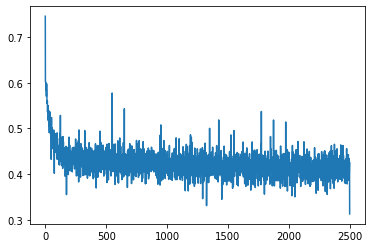

In [26]:
plt.plot(range(len(losses)), losses)

In [27]:
x_continius_train, x_categorical_train, y_train = train_ds.reverse_transform()

In [28]:
x_continius_test, x_categorical_test, y_test = test_ds.reverse_transform()

### Validating the net

In [29]:
y_train_pred = model.predict(train_dl_for_prediction).numpy().squeeze()

In [30]:
y_test_pred = model.predict(test_dl).numpy().squeeze()

In [31]:
aucroc_train = roc_auc_score(y_train, y_train_pred)
print(f'Auc Roc in training: {aucroc_train}')

Auc Roc in training: 0.9190385276392666


In [32]:
accuracy_train = accuracy_score(y_train, [1 if pred >= .5 else 0 for pred in y_train_pred])
print(f'Accuracy in training: {accuracy_train}')

Accuracy in training: 0.8689129263541796


In [33]:
aucroc_test = roc_auc_score(y_test, y_test_pred)
print(f'Auc Roc in test: {aucroc_test}')

Auc Roc in test: 0.8793694960736893


In [34]:
accuracy_test = accuracy_score(y_test, [1 if pred >= .5 else 0 for pred in y_test_pred])
print(f'Accuracy in test: {accuracy_test}')

Accuracy in test: 0.841869716558926
